In [5]:
!pip install transformers[sentencepiece] datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 14.8 MB/s 
     |████████████████████████████████| 451 kB 76.9 MB/s 
     |████████████████████████████████| 212 kB 78.1 MB/s 
     |████████████████████████████████| 132 kB 72.1 MB/s 
     |████████████████████████████████| 182 kB 53.9 MB/s 
     |████████████████████████████████| 127 kB 70.4 MB/s 
     |████████████████████████████████| 7.6 MB 50.1 MB/s 
     |████████████████████████████████| 1.3 MB 51.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [6]:
pip install torch>=1.6.0 transformers>=4.0.0

In [7]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from datasets import DatasetDict
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoConfig, AutoTokenizer, AutoModel
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.utils import resample

In [9]:
df = pd.read_csv('digikala_comments.csv', encoding='utf-8')
df.head()

,Text,Score,Suggestion
0,این اولین تجربه من برای خرید ایفون هست امروز...,100,1
1,خرید این محصول رو توصیه میکنم,84,1
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,60,1
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,96,1
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,92,1


In [10]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")



There are 1 GPU(s) available.
Device name: Tesla T4


# Preprocess data

In [11]:
df.drop(columns=['Score'], axis=1, inplace=True)

In [12]:
df['Suggestion'].unique()

array([1, 3, 2])

In [13]:
df['Suggestion'] = df['Suggestion'].replace(2, 1)
df['Suggestion'] = df['Suggestion'].replace(3, 0)

In [14]:
df['Suggestion'].unique()

array([1, 0])

In [15]:
df['Suggestion'].value_counts()

1    2801
0     460
Name: Suggestion, dtype: int64

# handle imbalance classificaton

In [16]:
df_minority = df[df['Suggestion']==0]
df_majority = df[df['Suggestion']==1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=103) # reproducible results
 
# Combine majority class with upsampled minority class
df = pd.concat([df_majority, df_minority_upsampled])

In [17]:
df['Suggestion'].value_counts()

1    2801
0    2801
Name: Suggestion, dtype: int64

In [18]:
df.head()

,Text,Suggestion
0,این اولین تجربه من برای خرید ایفون هست امروز...,1
1,خرید این محصول رو توصیه میکنم,1
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,1
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,1
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,1


# train test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df["Text"].values, df["Suggestion"].values, test_size=0.3, shuffle=True)

In [20]:
train = pd.DataFrame(list(zip(list(X_train), list(y_train))), columns =['Text', 'label'])

In [21]:
test = pd.DataFrame(list(zip(list(X_test), list(y_test))), columns =['Text', 'label'])

In [22]:
test

,Text,label
0,کیفیتش قابل قبوله اما عالی نیست انتظار منو که ...,1
1,اصلا پیشنهاد نمیکنم بخرین من خریدم تو شگفت ا...,0
2,درسته قیمتش بالاست اما خدایش ارزششو داشت رنگش ...,1
3,بعد از یک ماه استفاده خیلی بی دلیل صدای یکی از...,0
4,پر سرو صدا دگمه ها به زودی از کار افتاده و به ...,0
...,...,...
1676,سلام این دوربن و حدودا یک سال پیش از دیجی کالا...,1
1677,بزرگترین عیبش اینه که نمایشگر نداره و اصلا متو...,0
1678,اگه هدفون ارزون میخوایید بخرید,1
1679,با سلام به همه دوستان من این هندزفری رو تقریبا...,0


# create dataset dictionary

In [23]:
import datasets
dataset = DatasetDict()
train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)
questions = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})

questions


DatasetDict({
    train: Dataset({
        features: ['Text', 'label'],
        num_rows: 3921
    })
    test: Dataset({
        features: ['Text', 'label'],
        num_rows: 1681
    })
})

In [24]:
questions["train"]

Dataset({
    features: ['Text', 'label'],
    num_rows: 3921
})

# tokenize using Bert

In [25]:
checkpoint = "HooshvareLab/bert-base-parsbert-uncased"

In [26]:
# parsebert
config = AutoConfig.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModel.from_pretrained(checkpoint,output_hidden_states=True)

Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
def tokenize(batch, max_length=50):
#     tokenized_text = tokenizer.tokenize(batch["Text"], max_length=max_length, pad_to_max_length=True )
#     indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
#     return indexed_tokens
    return tokenizer(batch["Text"], max_length=max_length, pad_to_max_length=True )

In [28]:
train_questions = questions["train"].map(tokenize, batched=True, batch_size=None)
test_questions = questions["test"].map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

In [29]:
test_questions

Dataset({
    features: ['Text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1681
})

In [30]:
#tokenize using dataloader
# questions_encoded = questions.map(tokenize_function, batched=True, batch_size=None)
# questions_encoded

In [31]:
# #tokenize for test
# indexed_tokens = tokenize("چگونه فیش حقوقی را دریافت کنم؟")
# import torch# Convert inputs to PyTorch tensors
# tokens_tensor = torch.tensor([indexed_tokens])# Put the model in "evaluation" mode,meaning feed-forward operation.


# create data loader

In [32]:
train_ids = torch.tensor(train_questions["input_ids"])
train_attention_masks = torch.tensor(train_questions["attention_mask"])
train_labels = torch.tensor(train_questions["label"])

In [33]:
train_labels

tensor([0, 0, 0,  ..., 1, 0, 0])

In [34]:
train_ids = torch.tensor(train_questions["input_ids"])
train_attention_masks = torch.tensor(train_questions["attention_mask"])
train_labels = torch.tensor(train_questions["label"])

In [35]:
test_ids = torch.tensor(test_questions["input_ids"])
test_attention_masks = torch.tensor(test_questions["attention_mask"])
test_labels = torch.tensor(test_questions["label"])

In [36]:
test_labels

tensor([1, 0, 1,  ..., 1, 0, 0])

In [37]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
test_data = TensorDataset(test_ids, test_attention_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# create model

In [80]:
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2
        print('iniiiit')
        # Instantiate BERT model
        #self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert = AutoModel.from_pretrained(checkpoint)

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        print('forward')

        print('*******************')
        print(outputs.shape)
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)
        
        return logits


# Optimizer & Learning Rate Scheduler

In [39]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

# Training Loop

In [55]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()


train_loss = []
training_accuracy = []

test_loss = []
test_accuracy = []

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                train_loss.append(batch_loss / batch_counts)
                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        test_loss.append(loss.item())
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)
        test_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [56]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=5)
train(bert_classifier, train_dataloader, test_dataloader, epochs=5, evaluation=True)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implemen

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.619819   |     -      |     -     |   6.35   
   1    |   40    |   0.463772   |     -      |     -     |   6.24   
   1    |   60    |   0.340419   |     -      |     -     |   6.23   
   1    |   80    |   0.348554   |     -      |     -     |   6.07   
   1    |   100   |   0.286221   |     -      |     -     |   5.99   
   1    |   120   |   0.214844   |     -      |     -     |   5.92   
   1    |   122   |   0.342438   |     -      |     -     |   0.49   
----------------------------------------------------------------------
   1    |    -    |   0.380303   |  0.164004  |   94.58   |   41.68  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------------

# plot loss 

In [64]:
# plot training loss

In [57]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training loss')

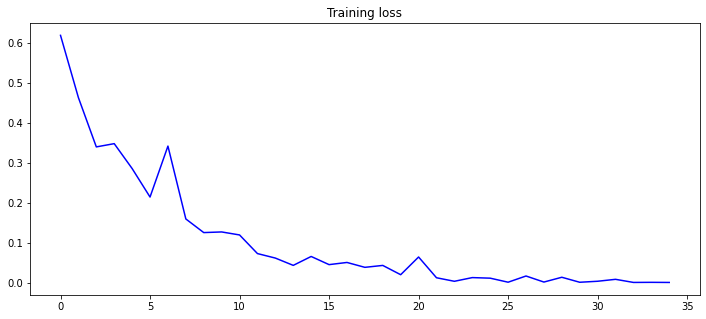

In [61]:
plt.figure(figsize=(12, 5))
plt.plot(train_loss, 'b', label='Training loss')
plt.title('Training loss')

# predict test textes

In [91]:
sample_text1 = 'اصلا محصول خوبی نبود و اصلا آن را توصیه نمیکنم'
sample_text2 = 'محصول خوبیه از خریدش راضی هستم'

test_tokenize1 = tokenizer(sample_text1, max_length=50, pad_to_max_length=True )
test_tokenize2 = tokenizer(sample_text2, max_length=50, pad_to_max_length=True )

ids = [test_tokenize1["input_ids"],test_tokenize2["input_ids"]]
masks = [test_tokenize1["attention_mask"],test_tokenize2["attention_mask"]]

input_ids = torch.tensor(ids).to(device)
attention_mask = torch.tensor(masks).to(device)


print(input_ids.shape)
print(attention_mask.shape)
logits = bert_classifier(input_ids, attention_mask)
preds = torch.argmax(logits, dim=1).flatten()
preds

torch.Size([2, 50])
torch.Size([2, 50])


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


tensor([0, 1], device='cuda:0')